In [1]:
import cv2 as cv
from os import listdir
import preprocess_lego_image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
tf.config.list_physical_devices('GPU')

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Note that manually loading and examining the data was an interesting exercise. However, I recently learned about the Keras built-in method [load_data_set_from_directory](https://keras.io/api/preprocessing/image/) that can probably replace a lot of the code below.
[The Keras transfer learning documentation](https://keras.io/guides/transfer_learning/#an-endtoend-example-finetuning-an-image-classification-model-on-a-cats-vs-dogs-dataset) has a nice example that could be used as a guideline for refactoring this.

In [2]:
data_dir_labeled = '..\\data\\labeled'
labels = listdir(data_dir_labeled)
labels.sort()
labels

['15712tile1x1withopenoclip', '3023plate1x2', '43857liftarmthick1x2']

In [3]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
def load_data():
    data = []
    for label in labels:
        label_path = f'{data_dir_labeled}\\{label}'
        image_paths = listdir(label_path)
        for image_path in image_paths:                
            image = preprocess_lego_image.preprocess(f'{label_path}\\{image_path}')
            data.append([label, image])
    return data

labeled_data = load_data()

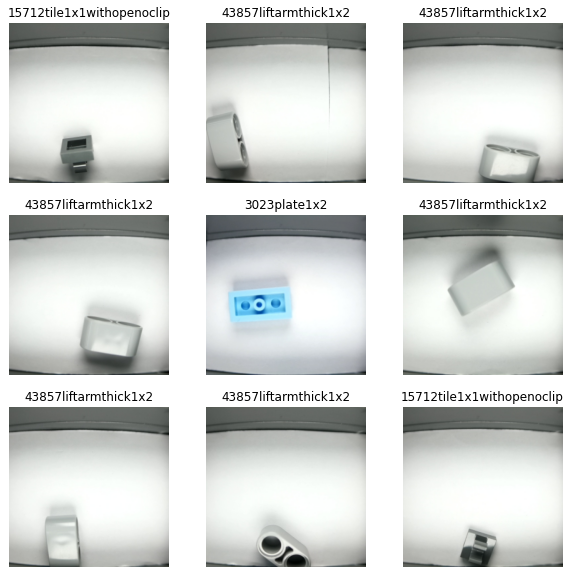

In [4]:
plt.figure(figsize=(10, 10))
i = 0
for label, image in random.sample(labeled_data, 9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis("off")
    i = i + 1

In [5]:
df = pd.DataFrame(labeled_data,columns = ['label','image'])
data_train = df.sample(frac=0.8, random_state=1)
data_test = df.drop(data_train.index)
print(f'# training data: {len(data_train)}')
print(f'# training data: {len(data_test)}')

# training data: 170
# training data: 42


In [6]:
from tensorflow.keras.utils import to_categorical
X_train = np.array(data_train.drop(['label'], axis=1))
y_train = to_categorical(np.array(data_train['label'].apply(lambda l: labels.index(l))))
X_test = np.array(data_test.drop(['label'], axis=1))
y_test = to_categorical(np.array(data_test['label'].apply(lambda l: labels.index(l))))

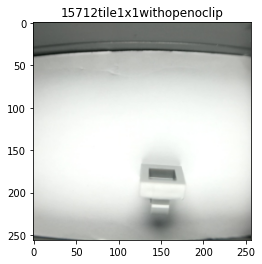

In [7]:
#sanity check
plt.title(labels[np.argmax(y_train[6])])
plt.imshow(cv.cvtColor(X_train[6][0], cv.COLOR_BGR2RGB))

In [8]:
L = []
for k in X_train:
    L += [k[0]]
L = np.array(L)
X_train = L
X_train.shape

(170, 256, 256, 3)

In [9]:
P = []
for k in X_test:
    P += [k[0]]
P = np.array(P)
X_test = P
X_test.shape

(42, 256, 256, 3)

In [10]:
X_test[0].shape

(256, 256, 3)

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
X_test = preprocess_input(X_test)
X_train = preprocess_input(X_train)
X_test.shape

(42, 256, 256, 3)

In [12]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
vgg16.trainable = False
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [24]:
model = tf.keras.models.Sequential()
model.add(vgg16)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(len(labels), activation='softmax'))

In [25]:
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [26]:
model.build([None, 256, 256, 3])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 387       
Total params: 31,558,467
Trainable params: 16,843,779
Non-trainable params: 14,714,688
_________________________________________________________________


In [27]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=200, verbose=1)

Epoch 1/50
1/1 [==============================] - 1s 893ms/step - loss: 0.4254 - accuracy: 0.3294 - val_loss: 0.4086 - val_accuracy: 0.3333
Epoch 2/50
1/1 [==============================] - 0s 263ms/step - loss: 0.4067 - accuracy: 0.3529 - val_loss: 0.3307 - val_accuracy: 0.4286
Epoch 3/50
1/1 [==============================] - 0s 260ms/step - loss: 0.3180 - accuracy: 0.4235 - val_loss: 0.4746 - val_accuracy: 0.2857
Epoch 4/50
1/1 [==============================] - 0s 261ms/step - loss: 0.4291 - accuracy: 0.3529 - val_loss: 0.4602 - val_accuracy: 0.3095
Epoch 5/50
1/1 [==============================] - 0s 262ms/step - loss: 0.4216 - accuracy: 0.3647 - val_loss: 0.4440 - val_accuracy: 0.3333
Epoch 6/50
1/1 [==============================] - 0s 261ms/step - loss: 0.3845 - accuracy: 0.4118 - val_loss: 0.2891 - val_accuracy: 0.5000
Epoch 7/50
1/1 [==============================] - 0s 262ms/step - loss: 0.2777 - accuracy: 0.5353 - val_loss: 0.3346 - val_accuracy: 0.4762
Epoch 8/50
1/1 [====

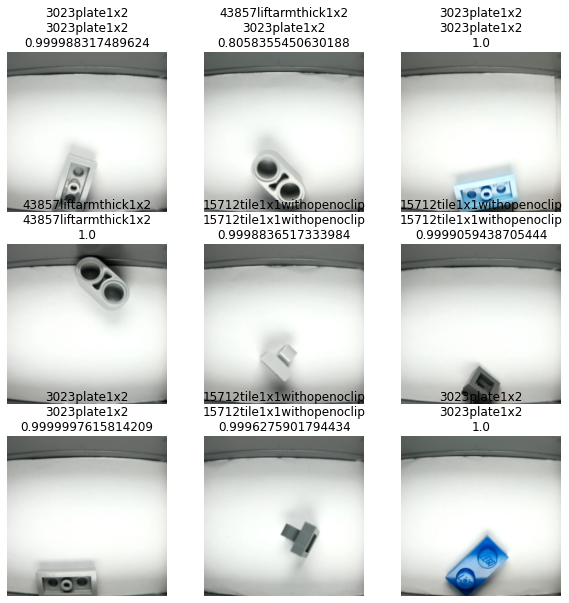

In [33]:
plt.figure(figsize=(10, 10))
i = 0
for label, image in random.sample(labeled_data, 9):
    ax = plt.subplot(3, 3, i + 1)
    expected_label, example_image = random.sample(labeled_data, 1)[0]
    prediction = model.predict(preprocess_input(np.array([example_image])))
    most_likely = np.argmax(prediction)
    predicted_label = labels[most_likely]
    predicted_prob = prediction[0][most_likely]
    plt.title(f'{expected_label}\n{predicted_label}\n{predicted_prob}')
    plt.imshow(cv.cvtColor(example_image, cv.COLOR_BGR2RGB))
    plt.axis("off")
    i = i + 1

In [29]:
# fine tuning
vgg16.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [30]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, verbose=1)

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 1.2461e-05 - accuracy: 1.0000 - val_loss: 0.0859 - val_accuracy: 0.8333
Epoch 2/20
1/1 [==============================] - 0s 252ms/step - loss: 2.4897e-06 - accuracy: 1.0000 - val_loss: 0.0858 - val_accuracy: 0.8333
Epoch 3/20
1/1 [==============================] - 0s 252ms/step - loss: 9.4071e-07 - accuracy: 1.0000 - val_loss: 0.0858 - val_accuracy: 0.8333
Epoch 4/20
1/1 [==============================] - 0s 251ms/step - loss: 4.9891e-07 - accuracy: 1.0000 - val_loss: 0.0857 - val_accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 0s 252ms/step - loss: 3.1933e-07 - accuracy: 1.0000 - val_loss: 0.0856 - val_accuracy: 0.8333
Epoch 6/20
1/1 [==============================] - 0s 252ms/step - loss: 2.2552e-07 - accuracy: 1.0000 - val_loss: 0.0856 - val_accuracy: 0.8333
Epoch 7/20
1/1 [==============================] - 0s 251ms/step - loss: 1.6867e-07 - accuracy: 1.0000 - val_loss: 0.0856 - val_accuracy: 0.

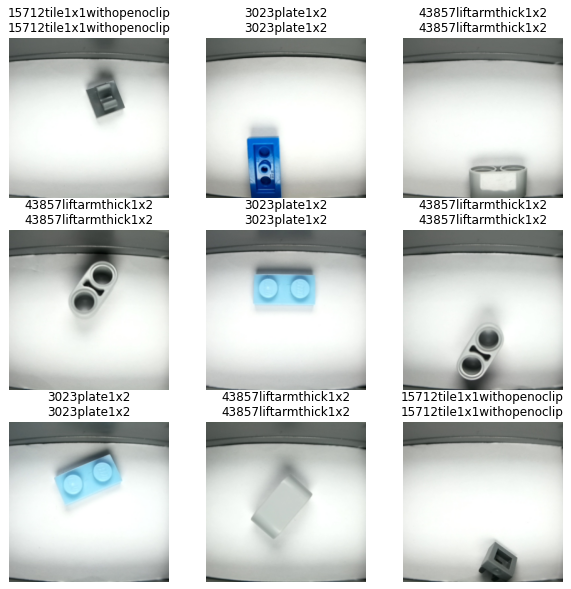

In [31]:
plt.figure(figsize=(10, 10))
i = 0
for label, image in random.sample(labeled_data, 9):
    ax = plt.subplot(3, 3, i + 1)
    expected_label, example_image = random.sample(labeled_data, 1)[0]
    prediction = model.predict(preprocess_input(np.array([example_image])))
    np.argmax(prediction)
    predicted_label = labels[np.argmax(prediction)]
    plt.title(f'{expected_label}\n{predicted_label}')
    plt.imshow(cv.cvtColor(example_image, cv.COLOR_BGR2RGB))
    plt.axis("off")
    i = i + 1

In [32]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets
